In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

/home/aviator98/anaconda3/envs/python3.11_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/aviator98/anaconda3/envs/python3.11_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_size = int(0.7 * len(full_train_dataset))
val_size = int(0.1 * len(full_train_dataset))
test_size = len(full_train_dataset) - train_size - val_size

train_dataset, val_dataset, _ = torch.utils.data.random_split(full_train_dataset, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(train_loader), len(val_loader), len(test_loader)) 

1313 188 313


In [3]:

class VAE_Classifier(nn.Module):
    def __init__(self, latent_dim=2, num_classes=10):
        super(VAE_Classifier, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)
        
        self.decoder_fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
        self.classifier = nn.Linear(latent_dim, num_classes)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        encoded = self.encoder(x)
        mu, logvar = self.fc_mu(encoded), self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder_fc(z).view(-1, 64, 7, 7)
        decoded = self.decoder(decoded)
        class_pred = self.classifier(z)
        return decoded, mu, logvar, class_pred, z

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/home/aviator98/anaconda3/envs/python3.11_env/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
# Define loss functions
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div


def plot_losses(vae_losses, cls_losses, epochs):
    plt.figure(figsize=(12, 5))

    # Plot VAE Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), vae_losses, label="VAE Loss", marker='o', color='b')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("VAE Loss vs. Epochs")
    plt.legend()
    plt.grid(True)

    # Plot Classification Loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), cls_losses, label="Classification Loss", marker='s', color='r')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Classification Loss vs. Epochs")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def train_vae_classifier(model, train_loader, epochs=10, latent_dim=2, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    classifier_criterion = nn.CrossEntropyLoss()

    vae_losses = []
    cls_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss, total_cls_loss = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            recon_images, mu, logvar, class_pred, _ = model(images)

            loss_vae = vae_loss(recon_images, images, mu, logvar)
            loss_cls = classifier_criterion(class_pred, labels)
            loss = loss_vae + loss_cls  # Combine losses

            loss.backward()
            optimizer.step()

            total_loss += loss_vae.item()
            total_cls_loss += loss_cls.item()

        # Store average losses per epoch
        avg_vae_loss = total_loss / len(train_loader)
        avg_cls_loss = total_cls_loss / len(train_loader)

        vae_losses.append(avg_vae_loss)
        cls_losses.append(avg_cls_loss)

        print(f"Epoch {epoch + 1}: VAE Loss = {avg_vae_loss:.4f}, Class Loss = {avg_cls_loss:.4f}")

    # Plot losses separately
    plot_losses(vae_losses, cls_losses, epochs)

    return model

# Counterfactual search with latent space interpolation
def find_counterfactual(model, image, label, num_steps=10):
    model.eval()
    image = image.unsqueeze(0).to(device)
    _, _, _, _, z = model(image)
    z = z.detach()
    
    # Find closest misclassified latent point
    min_dist, best_cf = float('inf'), None
    
    for x_cf, y_cf in train_loader.dataset:
        x_cf = x_cf.unsqueeze(0).to(device)
        _, _, _, _, z_cf = model(x_cf)
        z_cf = z_cf.detach()
        if torch.argmax(model.classifier(z_cf)).item() != label:  # Misclassified
            dist = torch.norm(z - z_cf).item()
            if dist < min_dist:
                min_dist = dist
                best_cf = z_cf
    
    # Latent space interpolation
    if best_cf is not None:
        interpolations = torch.linspace(0, 1, num_steps).to(device)
        images = []
        for alpha in interpolations:
            z_new = (1 - alpha) * z + alpha * best_cf
            decoded = model.decoder_fc(z_new).view(-1, 64, 7, 7)
            decoded = model.decoder(decoded)
            images.append(decoded.squeeze().cpu().detach().numpy())
        
        # Display counterfactual transition
        fig, axes = plt.subplots(1, num_steps, figsize=(15, 3))
        for i, img in enumerate(images):
            axes[i].imshow(img, cmap='gray')
            axes[i].axis('off')
        plt.show()
    else:
        print("No counterfactual found.")

Epoch 1: VAE Loss = 18576.3893, Class Loss = 2.1294
Epoch 2: VAE Loss = 17622.9511, Class Loss = 1.7171
Epoch 3: VAE Loss = 17366.6813, Class Loss = 1.5335
Epoch 4: VAE Loss = 17166.2965, Class Loss = 1.4103
Epoch 5: VAE Loss = 17033.9572, Class Loss = 1.3391
Epoch 6: VAE Loss = 16942.3765, Class Loss = 1.2917
Epoch 7: VAE Loss = 16882.3660, Class Loss = 1.2577
Epoch 8: VAE Loss = 16836.2409, Class Loss = 1.2344
Epoch 9: VAE Loss = 16800.8506, Class Loss = 1.2175
Epoch 10: VAE Loss = 16767.3636, Class Loss = 1.2033
Epoch 11: VAE Loss = 16735.0956, Class Loss = 1.1931
Epoch 12: VAE Loss = 16701.3327, Class Loss = 1.1812
Epoch 13: VAE Loss = 16681.2867, Class Loss = 1.1716
Epoch 14: VAE Loss = 16663.6792, Class Loss = 1.1658
Epoch 15: VAE Loss = 16643.2439, Class Loss = 1.1584
Epoch 16: VAE Loss = 16629.2579, Class Loss = 1.1542
Epoch 17: VAE Loss = 16616.5304, Class Loss = 1.1499
Epoch 18: VAE Loss = 16603.9536, Class Loss = 1.1486
Epoch 19: VAE Loss = 16592.1035, Class Loss = 1.1425
Ep

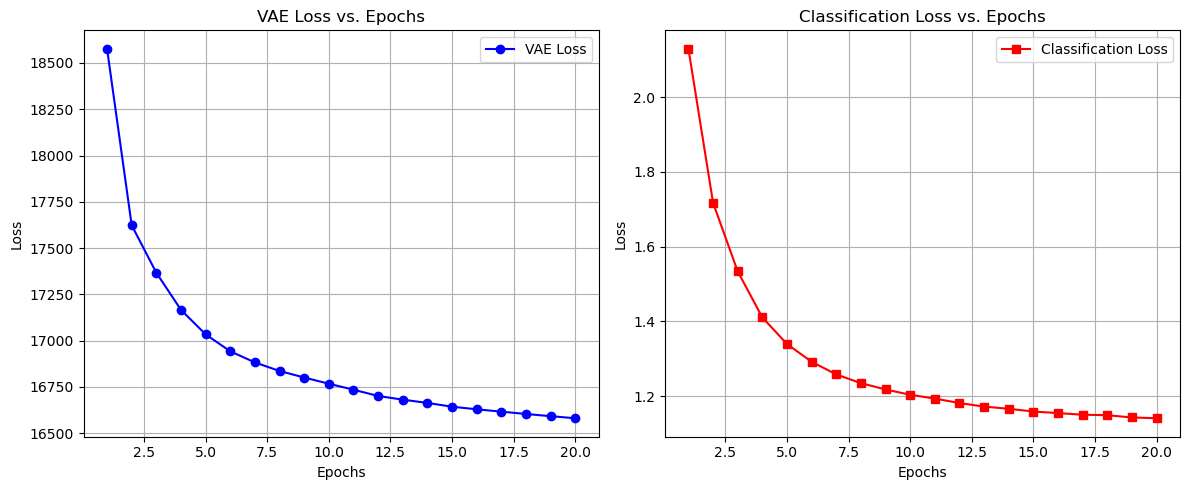

In [7]:
# Train model
latent_dim = 2
vae_classifier = VAE_Classifier(latent_dim).to(device)
vae_classifier = train_vae_classifier(vae_classifier, train_loader, epochs=20)

Finding counterfactual for class 7...


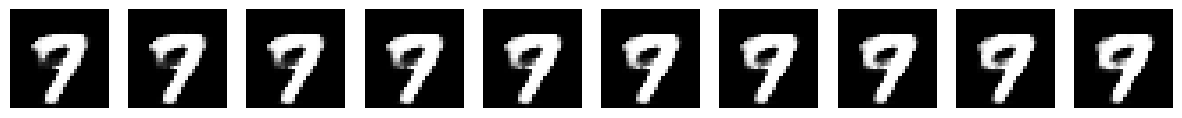

Finding counterfactual for class 2...


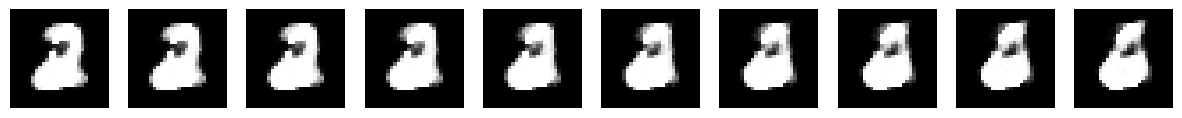

Finding counterfactual for class 1...


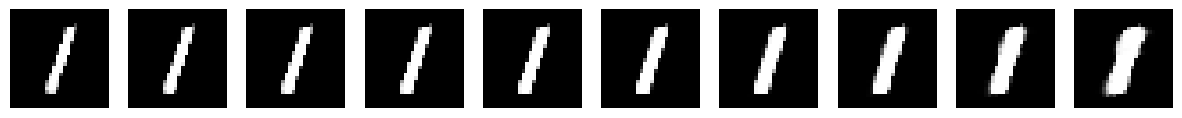

Finding counterfactual for class 0...


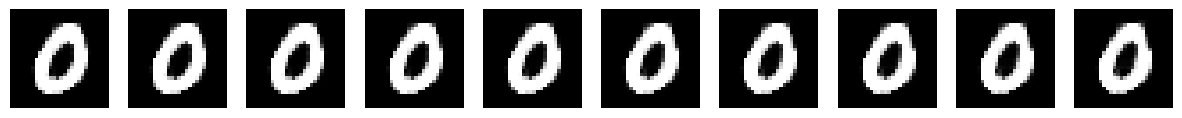

Finding counterfactual for class 4...


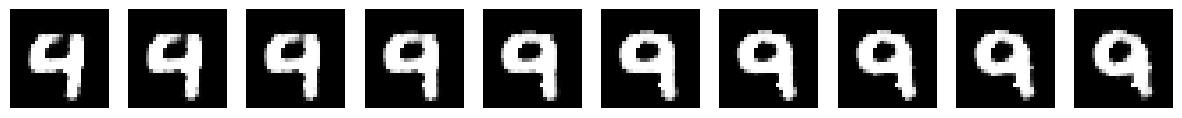

Finding counterfactual for class 9...


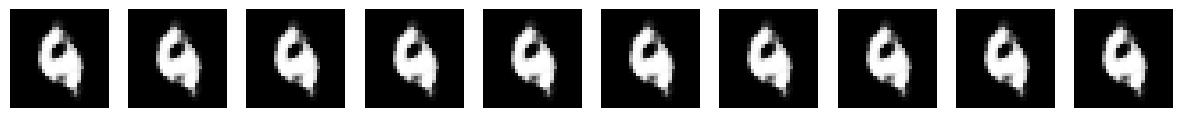

Finding counterfactual for class 5...


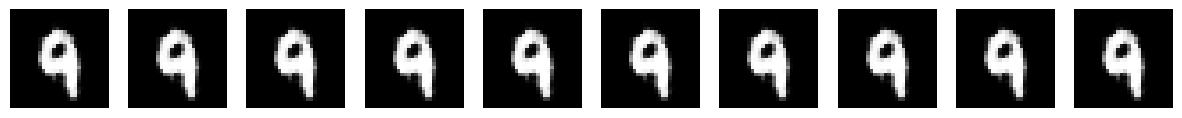

Finding counterfactual for class 6...


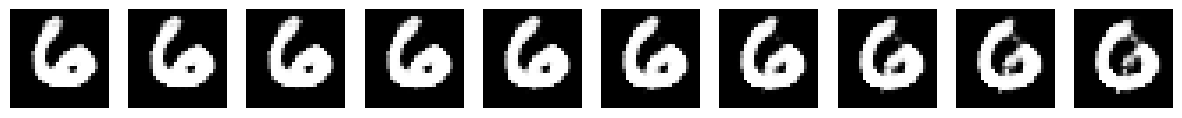

Finding counterfactual for class 3...


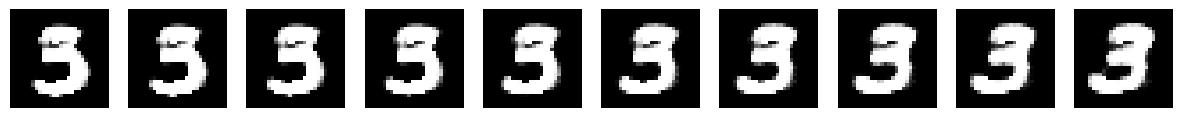

Finding counterfactual for class 8...


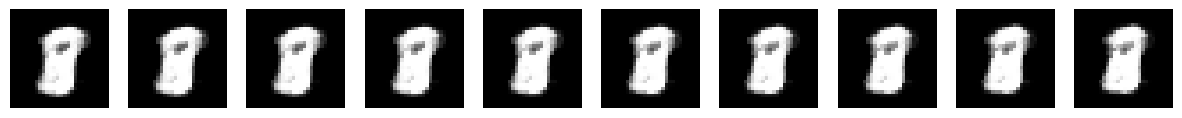

In [8]:
# Dictionary to store one sample per class
class_samples = {}

# Loop through the test_loader to extract one sample per class
for images, labels in test_loader:
    for image, label in zip(images, labels):
        label = label.item()
        if label not in class_samples:
            class_samples[label] = (image, label)
        if len(class_samples) == 10:  # Assuming 10 classes (0-9 for MNIST)
            break
    if len(class_samples) == 10:
        break

# Find and display counterfactuals for each class
for label, (sample_image, sample_label) in class_samples.items():
    print(f"Finding counterfactual for class {sample_label}...")
    find_counterfactual(vae_classifier, sample_image, sample_label)

In [9]:
from sklearn.metrics import classification_report

def generate_classification_report(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            _, _, _, class_pred, _ = model(images)
            predicted_labels = torch.argmax(class_pred, dim=1)

            # Store predictions and actual labels
            all_preds.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Generate and print the classification report
    report = classification_report(all_labels, all_preds, digits=4)
    print("Classification Report:\n", report)
    return report

# Run the function
generate_classification_report(vae_classifier, test_loader)


Classification Report:
               precision    recall  f1-score   support

           0     0.9074    0.9000    0.9037       980
           1     0.9186    0.9348    0.9266      1135
           2     0.5613    0.6609    0.6070      1032
           3     0.6153    0.6842    0.6479      1010
           4     0.6237    0.5957    0.6094       982
           5     0.1730    0.0661    0.0957       892
           6     0.7883    0.8476    0.8169       958
           7     0.5163    0.6313    0.5681      1028
           8     0.4895    0.5770    0.5297       974
           9     0.4458    0.3627    0.4000      1009

    accuracy                         0.6349     10000
   macro avg     0.6039    0.6260    0.6105     10000
weighted avg     0.6112    0.6349    0.6188     10000



'              precision    recall  f1-score   support\n\n           0     0.9074    0.9000    0.9037       980\n           1     0.9186    0.9348    0.9266      1135\n           2     0.5613    0.6609    0.6070      1032\n           3     0.6153    0.6842    0.6479      1010\n           4     0.6237    0.5957    0.6094       982\n           5     0.1730    0.0661    0.0957       892\n           6     0.7883    0.8476    0.8169       958\n           7     0.5163    0.6313    0.5681      1028\n           8     0.4895    0.5770    0.5297       974\n           9     0.4458    0.3627    0.4000      1009\n\n    accuracy                         0.6349     10000\n   macro avg     0.6039    0.6260    0.6105     10000\nweighted avg     0.6112    0.6349    0.6188     10000\n'

In [ ]:
def evaluate_classifier(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient tracking for efficiency
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass to get predictions
            _, _, _, class_pred, _ = model(images)
            predicted_labels = torch.argmax(class_pred, dim=1)  # Get predicted class
            
            correct += (predicted_labels == labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    print(f"Classifier Accuracy: {accuracy:.2f}%")
    return accuracy

# Run the accuracy check
evaluate_classifier(vae_classifier, test_loader)


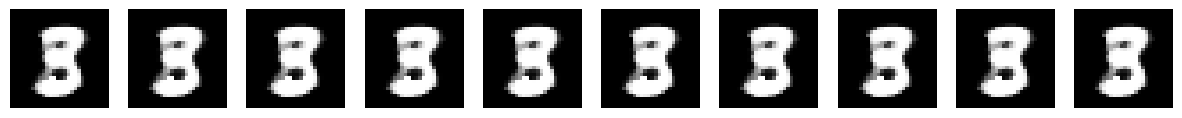

In [7]:
# Find counterfactuals for a test image
sample_image, sample_label = train_dataset[0]
find_counterfactual(vae_classifier, sample_image, sample_label)